In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!ls drive

 2016.txt   2018.txt  'Colab Notebooks'   отчет2


**Основные функции**

In [0]:
import numpy as np
import scipy
from scipy import special, sparse
%matplotlib inline  
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

In [0]:
class BaseSmoothOracle:
    
    def func(self, w):
        
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        
        raise NotImplementedError('Grad oracle is not implemented.')

        
class BinaryLogistic(BaseSmoothOracle):
    
    def __init__(self, l2_coef):
        
        self.l2_coef = l2_coef
     
    def func(self, X, y, w):
   
        m = X.dot(w) * y
        return self.l2_coef * w.dot(w) / 2 \
            + np.sum(np.logaddexp(np.zeros(m.shape[0]), -m)) / y.shape[0]
    
        
    def grad(self, X, y, w):
        
        m = scipy.special.expit(-X.dot(w) * y)
        if type(X) != scipy.sparse.csr.csr_matrix:
            return -np.dot(m, X * y.reshape(-1, 1)) / y.shape[0] + self.l2_coef * w
        else:
            return -X.T.dot(m * y) / y.shape[0] + self.l2_coef * w

In [0]:
class GDClassifier:
    
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, l2_coef = 0, **kwargs):

        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.gdc_classifier = BinaryLogistic(l2_coef)

        
    def fit(self, X, y, w_0=None, trace=False, accuracy = False, X_test = None, y_test = None):

        if w_0 is None:
            w_0 = np.zeros(X.shape[1])
        self.weight = w_0
        history = dict()
        history['time'] = [0]
        history['func'] = [self.get_objective(X, y)]
        if accuracy:
            history['accuracy'] = [np.mean(self.predict(X_test) == y_test)]
        for t in range(1, self.max_iter + 1):
            start = time.time()
            grad = self.get_gradient(X, y)
            step = self.step_alpha / (t ** self.step_beta)       
            self.weight = self.weight - step * grad
            end = time.time()
            history['time'].append(end - start)
            history['func'].append(self.get_objective(X, y))
            if accuracy:
                history['accuracy'].append(np.mean(self.predict(X_test) == y_test))
            if abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                print(t)
                break
        if trace:
            return history
        
    def predict(self, X):

        y = X.dot(self.weight)
        return (np.array([y>0]).astype(int) * 2 - 1).ravel()


    def predict_proba(self, X):

        return np.array([scipy.special.expit(X.dot(self.weight)).ravel(), 
                         1 - scipy.special.expit(X.dot(self.weight)).ravel()]).T
        
    def get_objective(self, X, y):

        return self.gdc_classifier.func(X, y, self.weight)       
        
    def get_gradient(self, X, y):
        
        return self.gdc_classifier.grad(X, y, self.weight)
    
    def get_weights(self):  
        
        return self.weight

In [0]:
np.random.seed(10)
clf = GDClassifier(loss_function='binary_logistic', batch_size = 10, step_alpha=1,
    step_beta=0, tolerance=1e-4, max_iter=1000, l2_coef=0.1)
l, d = 100, 10
X = scipy.sparse.csr_matrix(np.random.random((l, d)))
y = np.random.randint(0, 2, l) * 2 - 1
w = np.random.random(d)
history = clf.fit(X, y, w_0=np.zeros(d), trace=True, accuracy = True, X_test= X, y_test = y)
sum(clf.predict(X))

13


96

In [0]:
class SGDClassifier(GDClassifier):
    
    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, l2_coef= 0, **kwargs):
        
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.sgdc_classifier = BinaryLogistic(l2_coef)
        
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, accuracy = False, X_test = None, y_test = None):
        
        if w_0 is None:
            w_0 = np.random.sample(X.shape[1])
        self.weight = w_0

        r = np.random.seed(self.random_seed)
        history = dict()
        history['time'] = [0]
        history['func'] = [self.get_objective(X, y)]
        history['epoch_num'] = [0]
        history['weights_diff'] = [0]
        if accuracy:
            history['accuracy'] = [np.mean(self.predict(X_test) == y_test)]
        start = time.time()
        prev_epoch = 0
        prev_weight = w_0
        cur_epoch = 0
        func_prev = self.get_objective(X, y)
        func_cur = self.get_objective(X, y)
        for t in range(1, self.max_iter + 1):
            cur_epoch = (t - 1) * self.batch_size / X.shape[0]
            
            if abs(cur_epoch - prev_epoch) > log_freq:
                end = time.time()
                history['time'].append(end - start)
                tmp = self.weight - prev_weight
                if accuracy:
                    history['accuracy'].append(np.mean(self.predict(X_test) == y_test))
                history['weights_diff'].append(tmp.dot(tmp))
                history['epoch_num'].append(cur_epoch)

                history['func'].append(self.get_objective(X, y))
                prev_epoch = cur_epoch
                start = time.time()

            idx = np.random.randint(0, X.shape[0], self.batch_size).astype(int) 
            #idx = np.random.uniform(0, X.shape[0], self.batch_size).astype(int) 

            batch_X = X[idx]
            batch_y = y[idx]
            grad = self.get_gradient(batch_X, batch_y)
            step = self.step_alpha / (t ** self.step_beta)    
            prev_weight = self.weight
            self.weight = self.weight - step * grad
            func_cur = self.get_objective(X, y)
            if abs(func_cur - func_prev) < self.tolerance:
                print(t)
                break
            func_prev = func_cur
            
        if trace:
            return history
        
        
    def get_objective(self, X, y):
        
        return self.sgdc_classifier.func(X, y, self.weight)
        
        
        
    def get_gradient(self, X, y):
        
        return self.sgdc_classifier.grad(X, y, self.weight)
        
        
    def predict(self, X):

        y = X.dot(self.weight)
        return (np.array([y>0]).astype(int) * 2 - 1).ravel()


    def predict_proba(self, X):

        return np.array([scipy.special.expit(X.dot(self.weight)).ravel(), 
                         1 - scipy.special.expit(X.dot(self.weight)).ravel()]).T
        

In [0]:
def grad_finite_diff(f, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
    result = np.zeros(w.shape[0])
    for i in range(w.shape[0]):
        e = np.zeros(w.shape[0])
        e[i] = 1
        result[i] = (f(w + eps * e) - f(w)) / eps
    return result

### ***Эксперименты***

In [7]:
data_train = pd.read_csv('drive/отчет2/toxic_train.csv')
data_test = pd.read_csv('drive/отчет2/toxic_test.csv')
data_train.head()

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False


In [0]:
data_train['comment_text'] = data_train['comment_text'].str.lower()
data_train['comment_text'] = data_train['comment_text'].apply(lambda s: re.sub(r'[^A-Za-z0-9]', ' ', s))

data_test['comment_text'] = data_test['comment_text'].str.lower()
data_test['comment_text'] = data_test['comment_text'].apply(lambda s: re.sub(r'[^A-Za-z0-9]', ' ', s))

data_train['is_toxic'] = data_train['is_toxic'].apply(lambda s: s * 2 - 1)
data_test['is_toxic'] = data_test['is_toxic'].apply(lambda s: s * 2 - 1)


In [9]:
data_train.head()

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,-1
1,1,d aww he matches this background colour i m s...,-1
2,2,hey man i m really not trying to edit war it...,-1
3,3,more i can t make any real suggestions on im...,-1
4,4,you sir are my hero any chance you remember...,-1


In [0]:
y_train = data_train['is_toxic'].values
y_test = data_test['is_toxic'].values

In [0]:
vect = CountVectorizer(min_df = 5)

In [12]:
X_train = vect.fit_transform(data_train['comment_text'])
X_test = vect.transform(data_test['comment_text'])
X_train

<52061x18253 sparse matrix of type '<class 'numpy.int64'>'
	with 2007174 stored elements in Compressed Sparse Row format>

In [13]:
X_train = X_train.toarray()
X_train = np.hstack((np.ones(X_train.shape[0]).reshape(-1, 1), X_train))
X_train = scipy.sparse.csr_matrix(X_train)

X_test = X_test.toarray()
X_test = np.hstack((np.ones(X_test.shape[0]).reshape(-1, 1), X_test))
X_test = scipy.sparse.csr_matrix(X_test)
X_test

<20676x18254 sparse matrix of type '<class 'numpy.float64'>'
	with 724058 stored elements in Compressed Sparse Row format>

In [0]:
alpha = [0.001, 0.01, 0.1, 0.8,  1, 2]
hist_alpha = []


for a in alpha:
    print(a)
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a,
    step_beta=0, tolerance=1e-7, max_iter=2000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), 
                      trace=True, accuracy = True, X_test = X_test, y_test = y_test)
    hist_alpha.append(history)

0.001
0.01
0.1
0.8
1
2


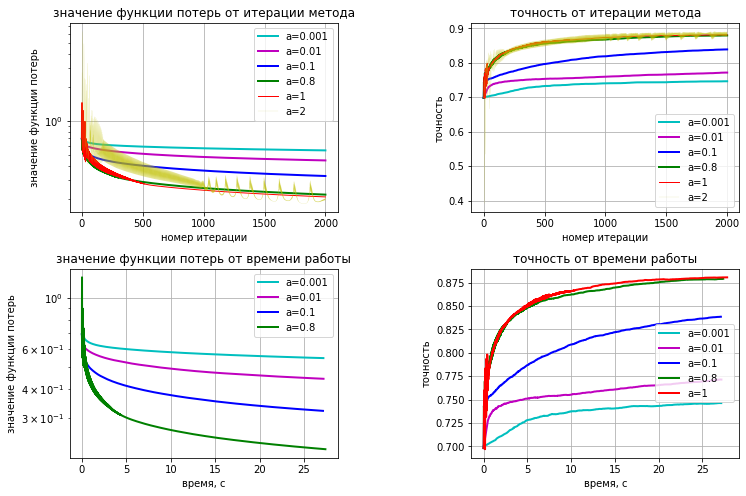

In [0]:
tm = [[],[], [], [], [], [], [], []]

for num_i, i in enumerate(hist_alpha):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)
alpha = [0.001, 0.01, 0.1, 0.8,  1, 2]

alpha = ['a='+str(s) for s in alpha]


cl = ['c', 'm', 'b', 'g', 'r', 'y', 'm', 'orange']
for i in range(4):
  ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['func'], cl[i], lw = '2')
  ax1.plot(tm[i], hist_alpha[i]['func'], cl[i], lw = '2')
  ax3.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['accuracy'], cl[i], lw='2')
  ax4.plot(tm[i], hist_alpha[i]['accuracy'], cl[i], lw = '2')
i = 4
ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['func'], cl[i], lw = '1')
ax3.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['accuracy'], cl[i], lw='1')
ax4.plot(tm[i], hist_alpha[i]['accuracy'], cl[i], lw = '2')

i = 5
ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['func'], cl[i], lw = '0.09')
ax3.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['accuracy'], cl[i], lw = '0.09')

ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(alpha)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(alpha)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(alpha)
ax4.grid()
ax3.set_xlabel('номер итерации')
ax3.set_ylabel('точность')
ax3.set_title("точность от итерации метода")
ax3.legend(alpha)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [14]:
beta = [0, 0.01, 0.1, 0.5, 1]
hist_beta = []

for b in beta:
    print(b)
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1,
    step_beta=b, tolerance=1e-8, max_iter=2000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)

    hist_beta.append(history)

0
0.01
0.1
0.5
1


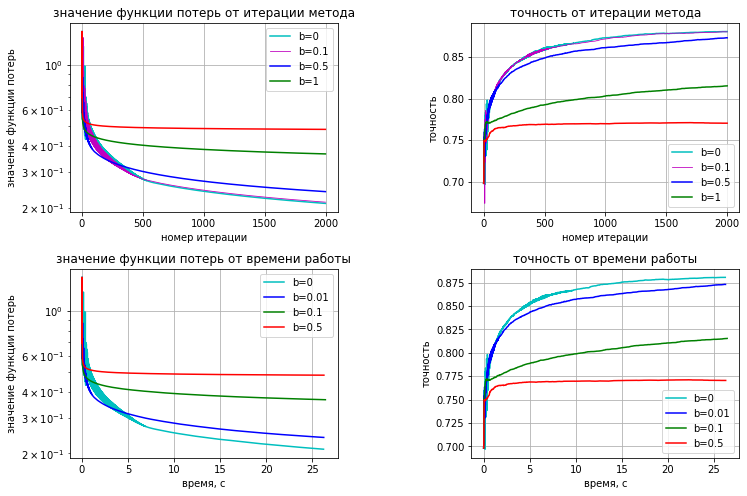

In [17]:
tm = [[],[], [], [], [], [], [], []]

for num_i, i in enumerate(hist_beta):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)
beta = [0, 0.01, 0.1, 0.5, 1]

beta = ['b='+str(s) for s in beta]

beta_1 = ['b='+str(s) for s in [0, 0.1, 0.5, 1]]

cl = ['c', 'm', 'b', 'g', 'r', 'y',  'orange']
for i in range(5):
    if i == 1:
        
        ax.plot(np.arange(len(hist_beta[i]['func'][:2000])), hist_beta[i]['func'][:2000], cl[i], lw = '0.8')
        ax3.plot(np.arange(len(hist_beta[i]['func'][:2000])), hist_beta[i]['accuracy'][:2000], cl[i], lw='0.8')
    else:
        ax.plot(np.arange(len(hist_beta[i]['func'][:2000])), hist_beta[i]['func'][:2000], cl[i])
        ax1.plot(tm[i][:2000], hist_beta[i]['func'][:2000], cl[i])
        ax3.plot(np.arange(len(hist_beta[i]['func'][:2000])), hist_beta[i]['accuracy'][:2000], cl[i])
        ax4.plot(tm[i][:2000], hist_beta[i]['accuracy'][:2000], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(beta)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(beta_1)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(beta)
ax4.grid()
ax3.set_xlabel('номер итерации')
ax3.set_ylabel('точность')
ax3.set_title("точность от итерации метода")
ax3.legend(beta_1)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
np.random.seed(10)

w_0 = np.zeros(X_train.shape[1])
w_1 = np.ones(X_train.shape[1])
w_r = np.random.sample(X_train.shape[1])

weight = [w_0, w_r, w_1]
hist_w = []

for w in weight:
    print(1)
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1,
                        step_beta=0, tolerance=1e-7, max_iter=2000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w, trace=True, 
                      accuracy = True, X_test = X_test, y_test = y_test)

    hist_w.append(history)

1
1
1


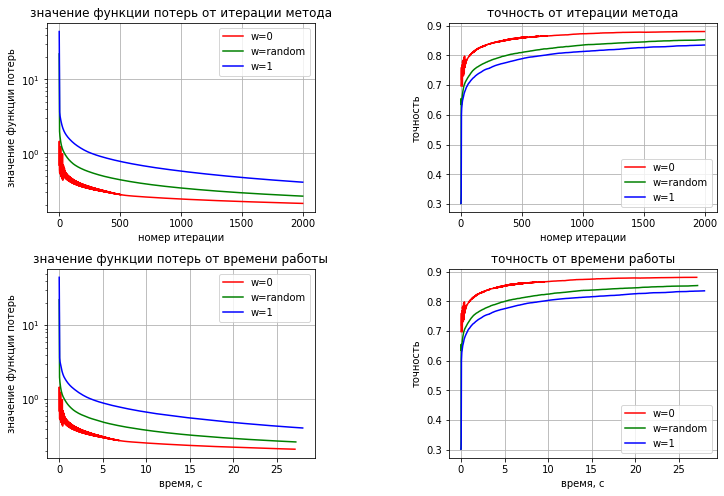

In [0]:
tm = [[],[], [], [], [], []]

for num_i, i in enumerate(hist_w):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)

leg = ['w=0', 'w=random', 'w=1']


cl = ['r', 'g', 'b', 'g', 'r', 'y',  'orange']
for i in range(3):
    ax.plot(np.arange(len(hist_w[i]['func'][:2000])), hist_w[i]['func'][:2000], cl[i])
    ax1.plot(tm[i][:2000], hist_w[i]['func'][:2000], cl[i])
    ax3.plot(np.arange(len(hist_w[i]['func'][:2000])), hist_w[i]['accuracy'][:2000], cl[i])
    ax4.plot(tm[i][:2000], hist_w[i]['accuracy'][:2000], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(leg)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(leg)
ax4.grid()
ax3.set_xlabel('номер итерации')
ax3.set_ylabel('точность')
ax3.set_title("точность от итерации метода")
ax3.legend(leg)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=0.01, tolerance=1e-7, max_iter=10000, l2_coef=0)
clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=False,
                      accuracy = False, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=1,
    step_beta=0, tolerance=1e-9, max_iter=9000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

In [0]:
max(history['accuracy']), np.argmax(history['accuracy'])

(0.8880344360611336, 8738)

In [0]:
history['accuracy'][8000]

0.8877442445347262

In [0]:
history['accuracy'][9000]

0.88788934029793

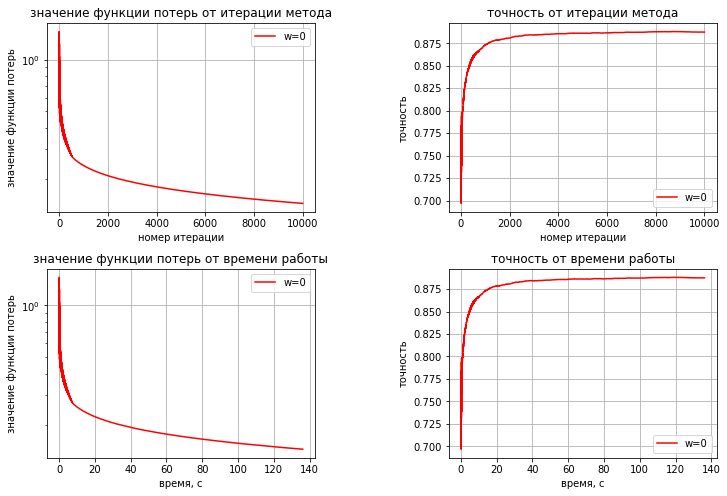

In [0]:
tm = [[],[], [], [], [], []]

hist_w[0] = history

sum_time = 0
for num_j, j in enumerate(history['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)

leg = ['w=0', 'w=random', 'w=1']


cl = ['r', 'g', 'b', 'g', 'r', 'y',  'orange']
for i in range(1):
    ax.plot(np.arange(len(hist_w[i]['func'])), hist_w[i]['func'], cl[i])
    ax1.plot(tm[i], hist_w[i]['func'], cl[i])
    ax3.plot(np.arange(len(hist_w[i]['func'])), hist_w[i]['accuracy'], cl[i])
    ax4.plot(tm[i], hist_w[i]['accuracy'], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(leg)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(leg)
ax4.grid()
ax3.set_xlabel('номер итерации')
ax3.set_ylabel('точность')
ax3.set_title("точность от итерации метода")
ax3.legend(leg)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


### ***Эксперимент 4***

In [0]:
alpha = [0.001, 0.01, 0.1, 0.5, 1, 2]
hist_alpha = []

for a in alpha:
    print(a)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = 1000, step_alpha=a,
    step_beta=0, tolerance=1e-8, max_iter=8000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), 
                      trace=True, accuracy = True, X_test = X_test, y_test = y_test)

    hist_alpha.append(history)

0.001
0.01
7566
0.1
879
0.5
1
7671
2


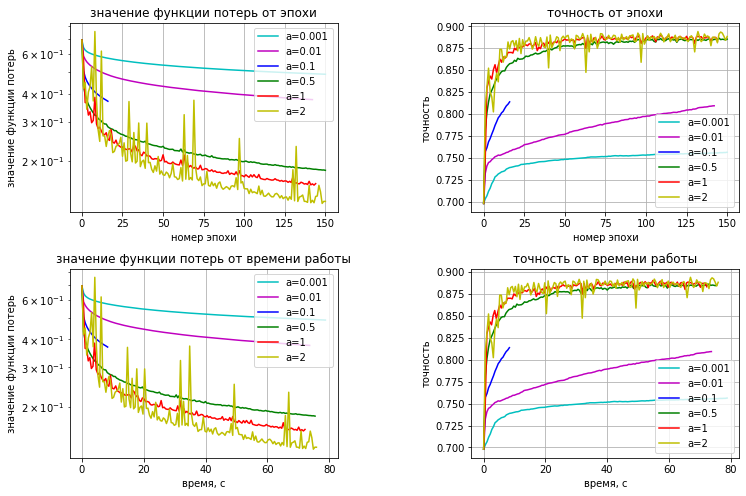

In [0]:
tm = [[],[], [], [], [], [], [], []]

for num_i, i in enumerate(hist_alpha):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)
alpha = [0.001, 0.01, 0.1, 0.5, 1, 2]

alpha = ['a='+str(s) for s in alpha]


cl = ['c', 'm', 'b', 'g', 'r', 'y', 'm', 'orange']
for i in range(6):
  ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['func'], cl[i])
  ax1.plot(tm[i], hist_alpha[i]['func'], cl[i])
  ax3.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['accuracy'], cl[i])
  ax4.plot(tm[i], hist_alpha[i]['accuracy'], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(alpha)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер эпохи')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от эпохи")
ax.legend(alpha)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(alpha)
ax4.grid()
ax3.set_xlabel('номер эпохи')
ax3.set_ylabel('точность')
ax3.set_title("точность от эпохи")
ax3.legend(alpha)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
beta = [0, 0.01, 0.1, 0.5, 1, 5]
hist_beta = []

for b in beta:
    print(b)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = 1000, step_alpha=1,
    step_beta=b, tolerance=1e-8, max_iter=8000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), 
                      trace=True, accuracy = True, X_test = X_test, y_test = y_test)

    hist_beta.append(history)

0
7671
0.01
0.1
1140
0.5
1746
1
5
43


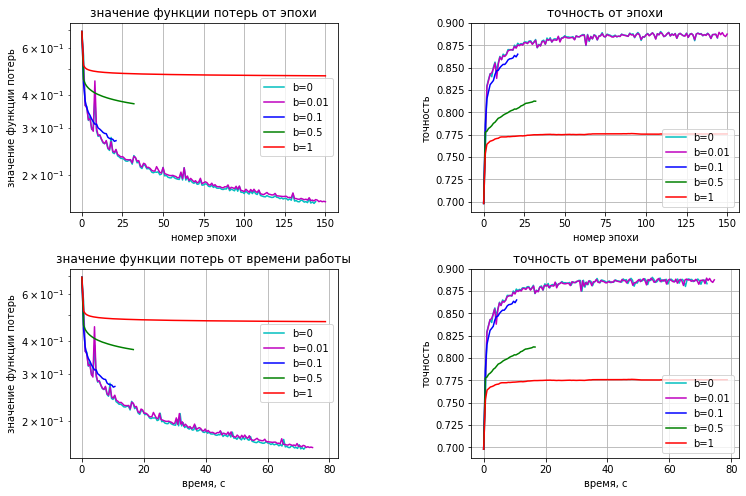

In [0]:
tm = [[],[], [], [], [], [], [], []]

for num_i, i in enumerate(hist_beta):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)
beta = [0, 0.01, 0.1, 0.5, 1]

beta = ['b='+str(s) for s in beta]


cl = ['c', 'm', 'b', 'g', 'r', 'y',  'orange']
for i in range(5):
  ax.plot(np.arange(len(hist_beta[i]['func'])), hist_beta[i]['func'], cl[i])
  ax1.plot(tm[i], hist_beta[i]['func'], cl[i])
  ax3.plot(np.arange(len(hist_beta[i]['func'])), hist_beta[i]['accuracy'], cl[i])
  ax4.plot(tm[i], hist_beta[i]['accuracy'], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(beta)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер эпохи')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от эпохи")
ax.legend(beta)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(beta)
ax4.grid()
ax3.set_xlabel('номер эпохи')
ax3.set_ylabel('точность')
ax3.set_title("точность от эпохи")
ax3.legend(beta)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
np.random.seed(10)

w_0 = np.zeros(X_train.shape[1])
w_1 = np.ones(X_train.shape[1])
w_r = np.random.sample(X_train.shape[1])

weight = [w_0, w_r, w_1]
hist_w = []

for w in weight:
    print(1)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = 1000, step_alpha=1,
                        step_beta=0, tolerance=1e-8, max_iter=8000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w, 
                    trace=True, accuracy = True, X_test = X_test, y_test = y_test)

    hist_w.append(history)

1
7671
1
1


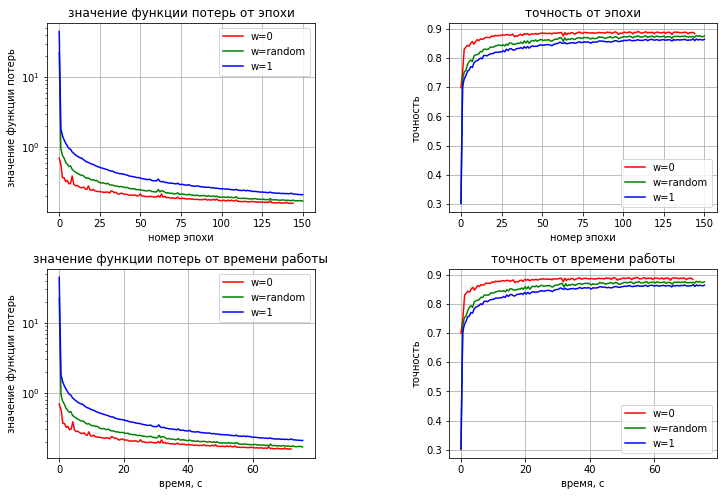

In [0]:
tm = [[],[], [], [], [], []]

for num_i, i in enumerate(hist_w):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)

leg = ['w=0', 'w=random', 'w=1']


cl = ['r', 'g', 'b', 'g', 'r', 'y',  'orange']
for i in range(3):
    ax.plot(np.arange(len(hist_w[i]['func'][:2000])), hist_w[i]['func'][:2000], cl[i])
    ax1.plot(tm[i][:2000], hist_w[i]['func'][:2000], cl[i])
    ax3.plot(np.arange(len(hist_w[i]['func'][:2000])), hist_w[i]['accuracy'][:2000], cl[i])
    ax4.plot(tm[i][:2000], hist_w[i]['accuracy'][:2000], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер эпохи')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от эпохи")
ax.legend(leg)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(leg)
ax4.grid()
ax3.set_xlabel('номер эпохи')
ax3.set_ylabel('точность')
ax3.set_title("точность от эпохи")
ax3.legend(leg)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=1, 
    step_beta=0.01, tolerance=1e-9, max_iter=80000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

49674


In [0]:
max(history['accuracy']), np.argmax(history['accuracy'])

(0.8906461597988006, 405)

In [0]:
max(history['accuracy']), np.argmax(history['accuracy'])

(0.8906461597988006, 405)

In [0]:
np.random.seed(10)

batch = [50, 100, 1000, 10000]
hist_w = []

for b in batch:
    print(b)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = b, step_alpha=1,
                        step_beta=0.001, tolerance=1e-9, max_iter=8000 * 1000 // b, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), 
                    trace=True, accuracy = True, X_test = X_test, y_test = y_test)

    hist_w.append(history)

50
100
1000
10000


In [0]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size = 50, step_alpha=1,
                        step_beta=0.001, tolerance=1e-8, max_iter=8000 * 1000 // 5, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), 
                trace=True, accuracy = True, X_test = X_test, y_test = y_test)

hist_w.append(history)

20629


In [0]:
len(hist_w)

6

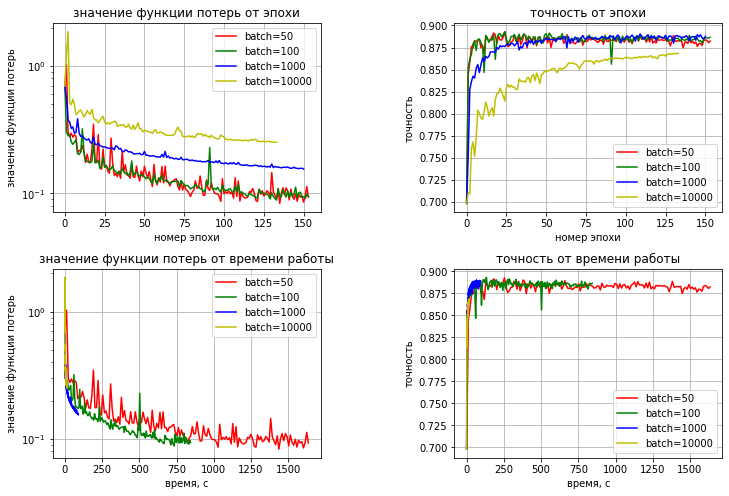

In [0]:
tm = [[],[], [], [], [], []]

for num_i, i in enumerate(hist_w):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)
batch = [50, 100, 1000, 10000]
leg = ['batch='+str(s) for s in batch]


cl = ['r', 'g', 'b', 'y', 'c', 'm',  'orange']
for i in range(4):
    ax.plot(np.arange(len(hist_w[i]['func'][:2000])), hist_w[i]['func'][:2000], cl[i])
    ax1.plot(tm[i][:2000], hist_w[i]['func'][:2000], cl[i])
    ax3.plot(np.arange(len(hist_w[i]['func'][:2000])), hist_w[i]['accuracy'][:2000], cl[i])
    ax4.plot(tm[i][:2000], hist_w[i]['accuracy'][:2000], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер эпохи')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от эпохи")
ax.legend(leg)
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.legend(leg)
ax4.grid()
ax3.set_xlabel('номер эпохи')
ax3.set_ylabel('точность')
ax3.set_title("точность от эпохи")
ax3.legend(leg)
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
7

7

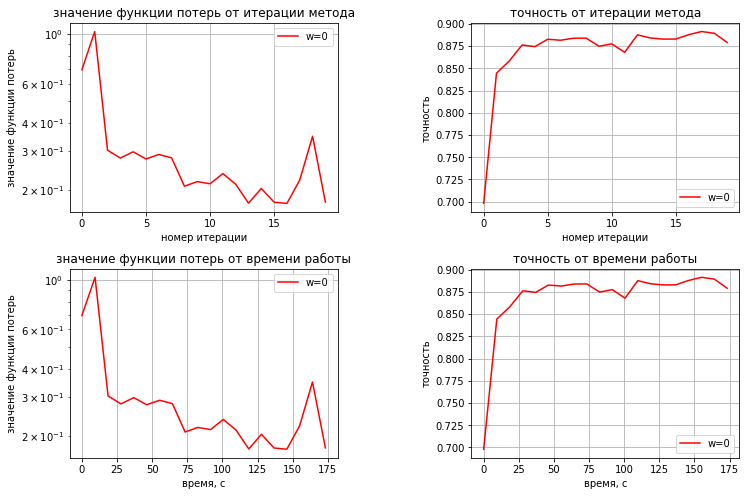

In [0]:
tm = [[],[], [], [], [], []]

hist_w[0] = history

sum_time = 0
for num_j, j in enumerate(history['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)

leg = ['w=0', 'w=random', 'w=1']


cl = ['r', 'g', 'b', 'g', 'r', 'y',  'orange']
for i in range(1):
    ax.plot(np.arange(len(hist_w[i]['func'])), hist_w[i]['func'], cl[i])
    ax1.plot(tm[i], hist_w[i]['func'], cl[i])
    ax3.plot(np.arange(len(hist_w[i]['func'])), hist_w[i]['accuracy'], cl[i])
    ax4.plot(tm[i], hist_w[i]['accuracy'], cl[i])


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")

ax4.grid()
ax3.set_xlabel('номер итерации')
ax3.set_ylabel('точность')
ax3.set_title("точность от итерации метода")
ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=1, 
    step_beta=0.01, tolerance=1e-9, max_iter=80000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

49674


In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=1, 
    step_beta=0.01, tolerance=1e-9, max_iter=9000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.8,
    step_beta=0, tolerance=1e-9, max_iter=9000, l2_coef=0)
history_gdc = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans_gdc = clf.predict(X_test)

In [0]:
tm = [[],[], [], [], [], []]

hist_w[0] = history
hist_w[1] = history_gdc


sum_time = 0
for num_j, j in enumerate(history['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_gdc['time']):
    tm[1].append(sum_time + j)
    sum_time = sum_time + j

fig = plt.figure(figsize=(12, 4))

ax1  = plt.subplot(121)
ax4  = plt.subplot(122)

leg = ['SGDC', 'GDC']


cl = ['r', 'g', 'b', 'g', 'r', 'y',  'orange']
for i in range(2):
    k = 9000
    ax1.plot(tm[i][:k], hist_w[i]['func'][:k], cl[i])
    ax4.plot(tm[i][:k], hist_w[i]['accuracy'][:k], cl[i])

    


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()


ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")
ax4.legend(leg)

ax4.grid()


plt.subplots_adjust(wspace=0.5, hspace=0.3)


NameError: ignored

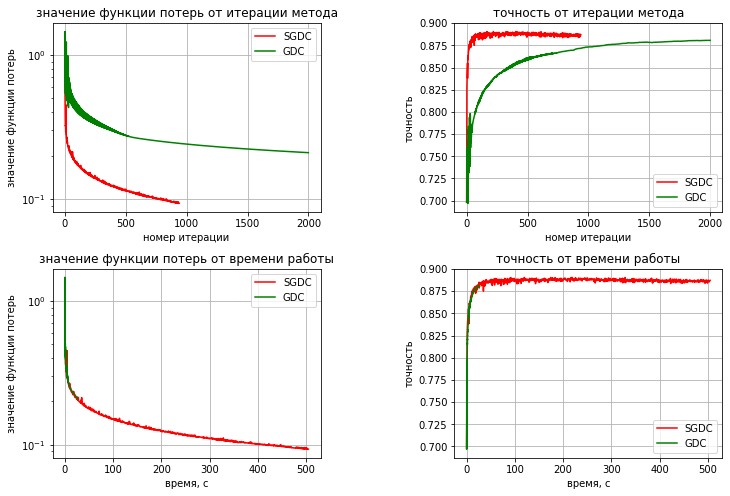

In [0]:
tm = [[],[], [], [], [], []]

hist_w[0] = history
hist_w[1] = history_gdc


sum_time = 0
for num_j, j in enumerate(history['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_gdc['time']):
    tm[1].append(sum_time + j)
    sum_time = sum_time + j

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(221)
ax1  = plt.subplot(223)
ax3  = plt.subplot(222)
ax4  = plt.subplot(224)

leg = ['SGDC', 'GDC']


cl = ['r', 'g', 'b', 'g', 'r', 'y',  'orange']
for i in range(2):
    ax.plot(np.arange(len(hist_w[i]['func']))[:2000], hist_w[i]['func'][:2000], cl[i])
    ax1.plot(tm[i][:2000], hist_w[i]['func'][:2000], cl[i])
    ax3.plot(np.arange(len(hist_w[i]['func']))[:2000], hist_w[i]['accuracy'][:2000], cl[i])
    ax4.plot(tm[i][:2000], hist_w[i]['accuracy'][:2000], cl[i])

    


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(leg)

ax.grid()

ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")
ax4.legend(leg)

ax4.grid()
ax3.set_xlabel('номер итерации')
ax3.set_ylabel('точность')
ax3.set_title("точность от итерации метода")
ax3.legend(leg)

ax3.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)


**Удаление стоп-слов, лемматизация**

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

lemmatizer.lemmatize("rocks")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'rock'

In [0]:
def del_stop_words(s):
    ans = []
    for a in s.split():
        b = lemmatizer.lemmatize(a)
        if b not in stopwords.words('english'):
            ans.append(b)
            
    return " ".join(ans)

In [0]:
import copy

In [0]:
train_d = copy.copy(data_train)
test_d = copy.copy(data_test)

In [0]:
train_d['comment_text'] = train_d['comment_text'].apply(lambda s: del_stop_words(s))

In [0]:
test_d['comment_text'] = test_d['comment_text'].apply(lambda s: del_stop_words(s))

In [0]:
vect = CountVectorizer(min_df = 5)
train = vect.fit_transform(train_d['comment_text'])
test = vect.transform(test_d['comment_text'])
test

<20676x16234 sparse matrix of type '<class 'numpy.int64'>'
	with 437679 stored elements in Compressed Sparse Row format>

In [0]:
train = train.toarray()
train = np.hstack((np.ones(train.shape[0]).reshape(-1, 1), train))
train = scipy.sparse.csr_matrix(train)

test = test.toarray()
test = np.hstack((np.ones(test.shape[0]).reshape(-1, 1), test))
test = scipy.sparse.csr_matrix(test)
test

<20676x16235 sparse matrix of type '<class 'numpy.float64'>'
	with 458355 stored elements in Compressed Sparse Row format>

In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=1,
                    step_beta=0, tolerance=1e-7, max_iter=10000, l2_coef=0)
history_lemm = clf.fit(train, y_train, w_0=np.zeros(train.shape[1]), trace=True, 
                    accuracy = True, X_test = test, y_test = y_test)

In [0]:
max(history_lemm['accuracy'])

0.8881311665699362

In [0]:
np.argmax(history_lemm['accuracy'])

9640

In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=1,
                    step_beta=0, tolerance=1e-7, max_iter=10000, l2_coef=0)
history_lemm_gdc = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, 
                    accuracy = True, X_test = X_test, y_test = y_test)

In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=1, 
    step_beta=0.01, tolerance=1e-10, max_iter=10000, l2_coef=0)
history_sgdc= clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)


In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=1, 
    step_beta=0.01, tolerance=1e-10, max_iter=10000, l2_coef=0)
history_sgdc_lemm = clf.fit(train, y_train, w_0=np.zeros(train.shape[1]), trace=True,
                      accuracy = True, X_test = test, y_test = y_test)
ans = clf.predict(test)

In [0]:
np.max(history_sgdc_lemm['accuracy']) 
#88.86

0.8892435674211646

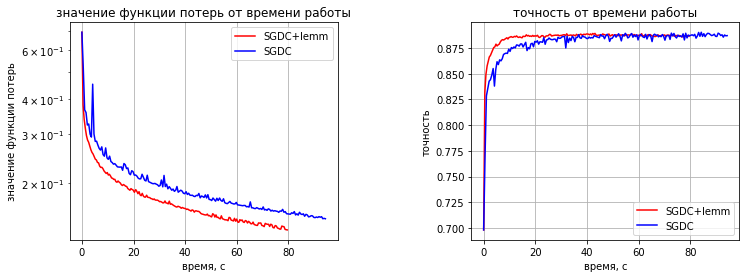

In [0]:
tm = [[],[], [], [], [], []]

hist_w=[0, 0, 0,0]
hist_w[0] = history_sgdc_lemm
hist_w[1] = history_lemm
hist_w[2] = history_sgdc
hist_w[3] = history_lemm_gdc

sum_time = 0
for num_j, j in enumerate(history_sgdc_lemm['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_lemm['time']):
    tm[1].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_sgdc['time']):
    tm[2].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_lemm_gdc['time']):
    tm[3].append(sum_time + j)
    sum_time = sum_time + j

fig = plt.figure(figsize=(12, 4))

ax1  = plt.subplot(121)
ax4  = plt.subplot(122)

leg = ['SGDC+lemm',  'SGDC', 'GDC']


cl = ['r', 'orange', 'b', 'y', 'r', 'y',  'orange']
for i in [0, 2]:
    k = 9000
    ax1.plot(tm[i][:k], hist_w[i]['func'][:k], cl[i])
    ax4.plot(tm[i][:k], hist_w[i]['accuracy'][:k], cl[i])

    


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()


ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")
ax4.legend(leg)

ax4.grid()


plt.subplots_adjust(wspace=0.5, hspace=0.3)


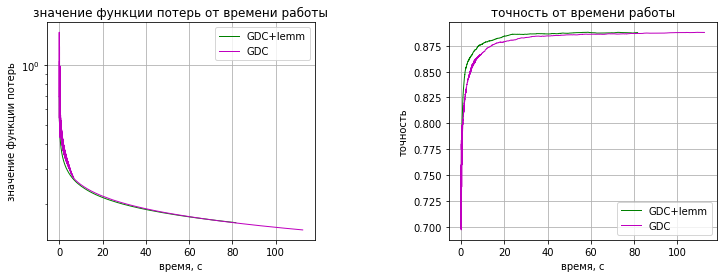

In [0]:
tm = [[],[], [], [], [], []]

hist_w=[0, 0, 0,0]
hist_w[0] = history_sgdc_lemm
hist_w[1] = history_lemm
hist_w[2] = history_sgdc
hist_w[3] = history_lemm_gdc

sum_time = 0
for num_j, j in enumerate(history_sgdc_lemm['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_lemm['time']):
    tm[1].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_sgdc['time']):
    tm[2].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_lemm_gdc['time']):
    tm[3].append(sum_time + j)
    sum_time = sum_time + j

fig = plt.figure(figsize=(12, 4))

ax1  = plt.subplot(121)
ax4  = plt.subplot(122)

leg = ['GDC+lemm',  'GDC', 'GDC']


cl = ['r', 'g', 'b', 'm', 'r', 'y',  'orange']
for i in [1, 3]:
    k = 9000
    ax1.plot(tm[i][:k], hist_w[i]['func'][:k], cl[i], lw='1')
    ax4.plot(tm[i][:k], hist_w[i]['accuracy'][:k], cl[i], lw = '1')

    


ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(leg)
ax1.grid()


ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы")
ax4.legend(leg)

ax4.grid()


plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
max(history_lemm['accuracy']), max(history_lemm_gdc['accuracy'])

(0.8881311665699362, 0.8880344360611336)

In [0]:
max(history_sgdc['accuracy']), max(history_sgdc_lemm['accuracy'])

(0.8903559682723932, 0.8892435674211646)

**Эксперимент 7**

In [0]:
vect = TfidfVectorizer(min_df = 5)
tf_train = vect.fit_transform(train_d['comment_text'])
tf_test = vect.transform(test_d['comment_text'])
tf_test

<20676x16234 sparse matrix of type '<class 'numpy.float64'>'
	with 437679 stored elements in Compressed Sparse Row format>

In [0]:
tf_train = tf_train.toarray()
tf_train = np.hstack((np.ones(tf_train.shape[0]).reshape(-1, 1), tf_train))
tf_train = scipy.sparse.csr_matrix(tf_train)

tf_test = tf_test.toarray()
tf_test = np.hstack((np.ones(tf_test.shape[0]).reshape(-1, 1), tf_test))
tf_test = scipy.sparse.csr_matrix(tf_test)
tf_test

<20676x16235 sparse matrix of type '<class 'numpy.float64'>'
	with 458355 stored elements in Compressed Sparse Row format>

In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=5,
    step_beta=0, tolerance=1e-7, max_iter=10000, l2_coef=0)
history_tf = clf.fit(tf_train, y_train, w_0=np.zeros(tf_train.shape[1]), trace=True,
                      accuracy = True, X_test = tf_test, y_test = y_test)
ans = clf.predict(tf_test)

In [0]:
np.max(history_tf['accuracy'])

0.891952021667634

In [0]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=5,
    step_beta=0, tolerance=1e-7, max_iter=10000, l2_coef=0)
history_gdc = clf.fit(train, y_train, w_0=np.zeros(train.shape[1]), trace=True,
                      accuracy = True, X_test = test, y_test = y_test)
ans = clf.predict(test)

In [0]:
np.max(history_gdc['accuracy']), np.argmax(history_gdc['accuracy'])

(0.8881795318243374, 1937)

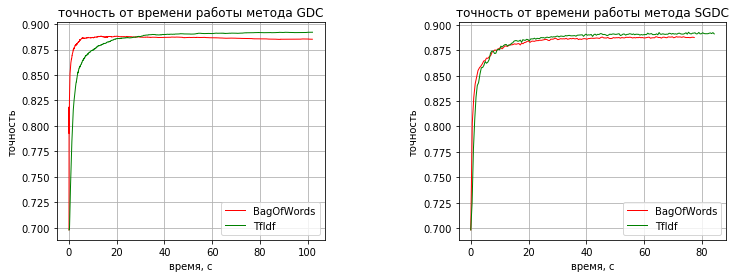

In [0]:
tm = [[],[], [], [], [], []]

hist_w=[0, 0, 0,0]
hist_w[0] = history_gdc
hist_w[1] = history_tf

hist_a=[0, 0, 0,0]
hist_w[2] = history_sgc
hist_w[3] = history_sgc_tf


sum_time = 0
for num_j, j in enumerate(history_gdc['time']):
    tm[0].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_tf['time']):
    tm[1].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_sgc['time']):
    tm[2].append(sum_time + j)
    sum_time = sum_time + j

sum_time = 0
for num_j, j in enumerate(history_sgc_tf['time']):
    tm[3].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 4))

ax4  = plt.subplot(121)
ax5 = plt.subplot(122)

leg = ['BagOfWords',  'TfIdf', 'GDC']


cl = ['r', 'g', 'b', 'm', 'r', 'y',  'orange']
for i in [0, 1]:
    k = 10000
    ax4.plot(tm[i][:k], hist_w[i]['accuracy'][:k], cl[i], lw = '1')
    ax5.plot(tm[i+2][:k], hist_w[i+2]['accuracy'][:k], cl[i], lw = '1')
    




ax4.set_xlabel('время, с')
ax4.set_ylabel('точность')
ax4.set_title("точность от времени работы метода GDC")
ax4.legend(leg)

ax4.grid()

ax5.set_xlabel('время, с')
ax5.set_ylabel('точность')
ax5.set_title("точность от времени работы метода SGDC")
ax5.legend(leg)

ax5.grid()


plt.subplots_adjust(wspace=0.5, hspace=0.3)


In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=5, 
    step_beta=0.01, tolerance=1e-9, max_iter=10000, l2_coef=0)
history_sgc_tf = clf.fit(tf_train, y_train, w_0=np.zeros(tf_train.shape[1]), trace=True,
                      accuracy = True, X_test = tf_test, y_test = y_test)
ans = clf.predict(tf_test)

In [0]:
np.max(history_sgc_tf['accuracy'])

0.8928709615012574

In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=1, 
    step_beta=0.001, tolerance=1e-9, max_iter=10000, l2_coef=0)
history_sgc = clf.fit(train, y_train, w_0=np.zeros(tf_train.shape[1]), trace=True,
                      accuracy = True, X_test = test, y_test = y_test)
ans = clf.predict(test)

8553


In [0]:
np.max(history_sgc['accuracy'])

0.888518088605146

In [0]:
alpha = [1, 2, 3, 4, 5]
hist_alpha = []


for a in alpha:
    print(a)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = 1000,  step_alpha=a, 
    step_beta=0.01, tolerance=1e-9, max_iter=10000, l2_coef=0)
    history = clf.fit(tf_train, y_train, w_0=np.zeros(train.shape[1]), 
                      trace=True, accuracy = True, X_test = tf_test, y_test = y_test)
    hist_alpha.append(history)

1
2
3
7247
4
5


In [0]:
tm = [[],[], [], [], [], [], [], []]

for num_i, i in enumerate(hist_alpha):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j

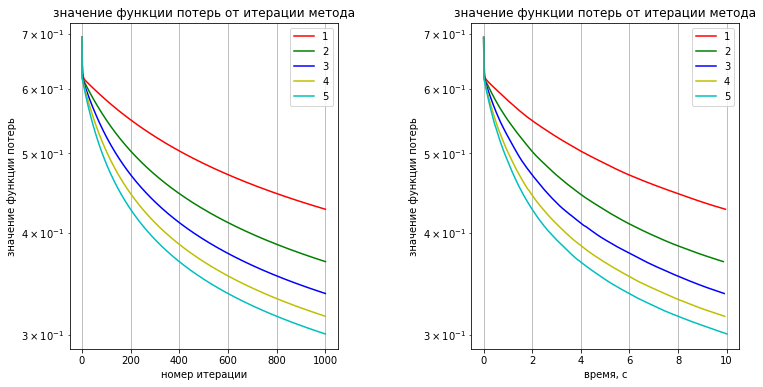

In [0]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
for i in range(5):
  ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['func'], cl[i])
  ax1.plot(tm[i], hist_alpha[i]['func'], cl[i])

ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от итерации метода")
ax1.legend(alpha)
ax1.grid()
ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(alpha)
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)


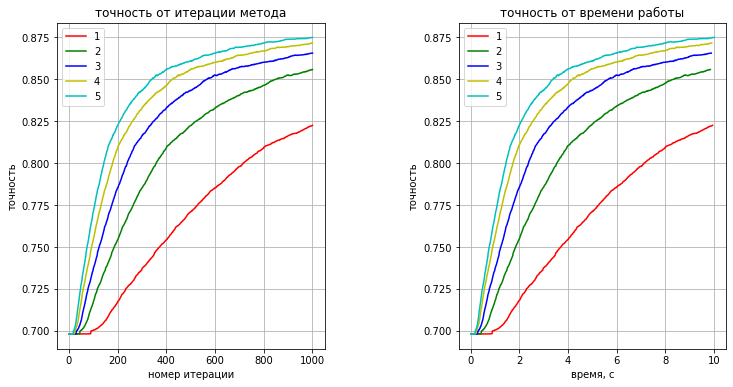

In [0]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred']
for i in range(5):
    ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['accuracy'], cl[i])
    ax1.plot(tm[i], hist_alpha[i]['accuracy'], cl[i])

ax1.set_xlabel('время, с')
ax1.set_ylabel('точность')
ax1.set_title("точность от времени работы")

ax1.legend(alpha)
ax1.grid()
ax.set_xlabel('номер итерации')
ax.set_ylabel('точность')
ax.set_title("точность от итерации метода")
ax.legend(alpha)
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)


In [0]:
beta = [0, 0.001, 0.01, 0.1]
hist_beta = []

for b in beta:
    print(b)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = 1000, step_alpha=5,
    step_beta=b, tolerance=1e-7, max_iter=1000, l2_coef=0)
    history = clf.fit(train, y_train, w_0=np.zeros(train.shape[1]), trace=True,
                      accuracy = True, X_test = test, y_test = y_test)

    hist_beta.append(history)

0
0.001
0.01
1000
0.1
662


In [0]:
tm = [[],[], [], [], [], [], []]

for num_i, i in enumerate(hist_beta):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j

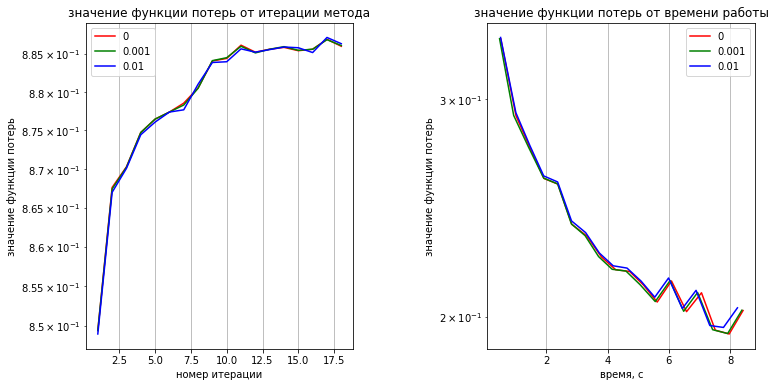

In [0]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred']
for i in range(3):
  ax.plot(np.arange(len(hist_beta[i]['func']))[1:], hist_beta[i]['accuracy'][1:], cl[i])
  ax1.plot(tm[i][1:], hist_beta[i]['func'][1:], cl[i])
ax1.set_yscale('log')
ax1.set_xlabel('время, с')
ax1.set_ylabel('значение функции потерь')
ax1.set_title("значение функции потерь от времени работы")
ax1.legend(beta)
ax1.grid()

ax.set_yscale('log')
ax.set_xlabel('номер итерации')
ax.set_ylabel('значение функции потерь')
ax.set_title("значение функции потерь от итерации метода")
ax.legend(beta)
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)


In [0]:
data_test['comment_text'].size

20676

In [0]:
arr = [20676, 300,200, 100,50, 10,  7, 4, 3, 1]
shapes_max = []
for max_df in arr:
    vect = CountVectorizer(max_df = max_df)
    X_train = vect.fit_transform(train_d['comment_text'])
    X_test = vect.transform(test_d['comment_text'])
    shapes_max.append(X_test.shape[1])
    print(max_df, X_test.shape[1])

In [0]:
shapes_min = []
for min_df in [0, 5, 10, 20, 30, 40, 50, 60, 70 , 80]:
    print(min_df)
    vect = CountVectorizer(min_df = min_df)
    X_train = vect.fit_transform(train_d['comment_text'])
    X_test = vect.transform(test_d['comment_text'])
    shapes_min.append(X_test.shape[1])

In [0]:
shapes_max

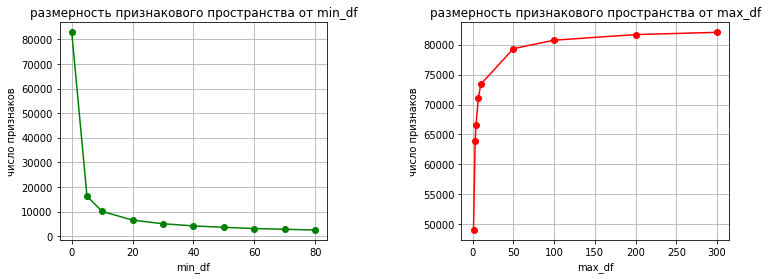

In [0]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred']

ax.plot([0, 5, 10, 20, 30, 40, 50, 60, 70 , 80], shapes_min, 'g', marker = 'o')
ax1.plot(arr[1:], shapes_max[1:], 'r', marker = 'o')


ax1.set_xlabel('max_df')
ax1.set_ylabel('число признаков')
ax1.set_title("размерность признакового пространства от max_df")

ax1.grid()
ax.set_xlabel('min_df')
ax.set_ylabel('число признаков')
ax.set_title("размерность признакового пространства от min_df")
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)


In [0]:
shapes_max = []
hist_max = []
for max_df in [5, 30, 100, 200, 300]:
    print(max_df)
    vect = TfidfVectorizer( max_df = max_df)
    X_train = vect.fit_transform(train_d['comment_text'])
    X_test = vect.transform(test_d['comment_text'])
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=2, 
    step_beta=0, tolerance=1e-9, max_iter= 2000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
    hist_max.append(history) 

5
30
100
200
300


In [0]:
shapes_max = []
hist_max = []
for max_df in [5, 30, 100, 200, 300]:
    print(max_df)
    vect = TfidfVectorizer( max_df = max_df)
    X_train = vect.fit_transform(train_d['comment_text'])
    X_test = vect.transform(test_d['comment_text'])
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=2, 
    step_beta=0, tolerance=1e-9, max_iter= 2000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
    hist_max.append(history) 

5
30
100
200
300


In [0]:
shapes_min = []
hist = []
for min_df in [5, 10, 20, 40, 80]:
    print(min_df)
    vect = CountVectorizer(min_df = min_df)
    X_train = vect.fit_transform(train_d['comment_text'])
    X_test = vect.transform(test_d['comment_text'])
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=2, 
    step_beta=0, tolerance=1e-9, max_iter= 2000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
    hist.append(history) 

5
10
20
40
80


In [0]:
tm_max = [[],[], [], [], [], [], []]

for num_i, i in enumerate(hist_max):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm_max[num_i].append(sum_time + j)
    sum_time = sum_time + j

In [0]:
tm = [[],[], [], [], [], [], []]

for num_i, i in enumerate(hist):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j

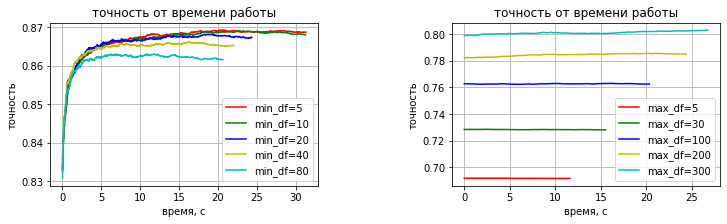

In [0]:
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred']

alpha = ['min_df='+str(s) for s in [5, 10, 20, 40, 80]]
beta  =['max_df='+str(s) for s in [5, 30, 100, 200, 300]]
for i in range(5):
    ax.plot(tm[i][3:], hist[i]['accuracy'][3:], cl[i])
    ax1.plot(tm_max[i][3:], hist_max[i]['accuracy'][3:], cl[i])

ax1.set_xlabel('время, с')
ax1.set_ylabel('точность')
ax1.set_title("точность от времени работы")

ax1.legend(beta)
ax1.grid()
ax.set_xlabel('время, с')
ax.set_ylabel('точность')
ax.set_title("точность от времени работы")
ax.legend(alpha)
ax.grid()

plt.subplots_adjust(wspace=0.5)


**Эксперимент 8**

In [0]:
np.argmax(history_sgc_tf['accuracy'])

145

In [0]:
X_train.shape

(52061, 82069)

In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=5, 
    step_beta=0.01, tolerance=1e-9, max_iter=8906, l2_coef=0)
history_sgc_tf_1 = clf.fit(tf_train, y_train, w_0=np.zeros(tf_train.shape[1]), trace=True,
                      accuracy = True, X_test = tf_test, y_test = y_test)
ans = clf.predict(tf_test)

8905


In [0]:
np.mean(ans == y_test)

0.8926775004836526

In [0]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix

In [0]:
sklearn.metrics.confusion_matrix(y_test, ans)

array([[13094,  1339],
       [  880,  5363]])

In [0]:
np.array(y_test == 1)  & np.array(ans  == -1)

array([False, False, False, ...,  True,  True, False])

In [0]:
for i in [300, 1, 127]:
    print(data_test[np.array(y_test == 1)  & np.array(ans  == -1)].comment_text.iloc[i]) #127 #1 #300

you are dead wrong  the falcons were 14 2   do your research before you edit something  on wikipedia                                   11
         moi  ego  i am mortified that you could say such a thing   poor old mona i always thiught she was a miserable looking woman   probably hormonal 
       this is laughable  the entire cadre is coming to get me  i didn t register a new username  so it s not a sock puppet  sorry to disappoint you  i was mocking docfisherking s use of ip address accounts in order to make it appear that there s more support for his position than there really is     ryodox            12 november 2006         also ostensibly   among other ip addresses  has a long history of repeatedly reverting my edits  and the edits of other users  to his own versions of the david duke page  with accusations of vandalism on my part in the edit summary             no truth in that statement  see for yourself        well  nice try      208 192 66 196      record type    ip address  

In [0]:
for i in[300, 500, 1337, 1334]:
    print(data_test[np.array(y_test == -1)  & np.array(ans  == +1)].comment_text.iloc[i]) 

   ultima linux talk page       what the hell 
        feeding off others parasites       a parasite gets its food from the living body of another organism called the host a parasite nibbles pieces off its host  sucks the host  s blood  etc  but unlike a predator   a parasite does not deliberately try to kill its host as this would kill its sourceof food  
   n  lnkfjjkghdfjgfjgfjhgiofj iojfoijio ioioh oidogj ugho diklffkljfiug mvljhjkg mfm blfjjfrtiupjhgre7tjy5ythjtrh5tr5h52te5 54gh5454h54hg5 45 54 54 5454 5454545 5  54 5 545 4545 45 45  4545 234gh5g4h8n5ythgdh546tyh877 3gfn   b 2352n5g65n6ggn56bfv 5561ghhg564jhg564j56gh4jgh564jk5gh64kj564ghk564gk564hgk5j4 54h56 4654 5645j4g564k564jkgh54 564mn564g56n4gh564jgh564nb54n 5bn4mn56g4n56 456n4g65ngb56 4bg56n4gh564gh564gh56gh56j65gh4j564j6545645nb456g4n56bf4n56b4n56b4 5b4 bg465b4 56b4 65b4 56b4 56g4 56g5g6mn4g564nfg5n4n4564b56 56 4n54b56n4bv65n56bvng5mngbm4nb564mn54564 564564  54 564n5645456 45m4n56m4n545 456m4 54 5645j4m5nb4 545bn4m5645hg4jh

In [0]:

train_d['comment_text'] = train_d['comment_text'].apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))

test_d['comment_text'] = test_d['comment_text'].apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))




In [0]:
vect = TfidfVectorizer(min_df = 5)

In [0]:
X_train = vect.fit_transform(train_d['comment_text'])
X_test = vect.transform(test_d['comment_text'])
X_train

<52061x15743 sparse matrix of type '<class 'numpy.float64'>'
	with 1218903 stored elements in Compressed Sparse Row format>

In [0]:
X_train = X_train.toarray()
X_train = np.hstack((np.ones(X_train.shape[0]).reshape(-1, 1), X_train))
X_train = scipy.sparse.csr_matrix(X_train)

X_test = X_test.toarray()
X_test = np.hstack((np.ones(X_test.shape[0]).reshape(-1, 1), X_test))
X_test = scipy.sparse.csr_matrix(X_test)
X_test

<20676x15744 sparse matrix of type '<class 'numpy.float64'>'
	with 451301 stored elements in Compressed Sparse Row format>

In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=5, 
    step_beta=0.01, tolerance=1e-9, max_iter=10000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

In [0]:
max(history['accuracy'])

0.8928225962468562

In [0]:
data_train = pd.read_csv('drive/отчет2/toxic_train.csv')
data_test = pd.read_csv('drive/отчет2/toxic_test.csv')


,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False


In [0]:
data_train['comment_text'] = data_train['comment_text'].apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
data_test['comment_text'] = data_test['comment_text'].apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))


In [0]:
def del_stop_words(s):
    ans = []
    for a in s.split():
        b = lemmatizer.lemmatize(a)
        if b.lower() not in stopwords.words('english'):
            ans.append(b)
            
    return " ".join(ans)

In [0]:
data_train['comment_text'] = data_train['comment_text'].apply(lambda s: del_stop_words(s))
data_test['comment_text'] = data_test['comment_text'].apply(lambda s: del_stop_words(s))

In [0]:
data_train['comment_text'] = data_train['comment_text'].apply(lambda s: s +'jdhfbfhb')
data_test['comment_text'] = data_test['comment_text'].apply(lambda s: s + 'jdhfbfhb')

In [0]:
vect = CountVectorizer(min_df = 5, lowercase = True, ngram_range = (1, 2))

In [0]:
X_train = vect.fit_transform(data_train['comment_text'])
X_test = vect.transform(data_test['comment_text'])
X_train

<52061x46669 sparse matrix of type '<class 'numpy.int64'>'
	with 1617835 stored elements in Compressed Sparse Row format>

In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=2, 
    step_beta=0.01, tolerance=1e-9, max_iter=10000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

In [0]:
max(history['accuracy'])

0.8754594699168118

In [0]:
X_train = X_train.toarray()
X_train = np.hstack((np.ones(X_train.shape[0]).reshape(-1, 1), X_train))
X_train = scipy.sparse.csr_matrix(X_train)

X_test = X_test.toarray()
X_test = np.hstack((np.ones(X_test.shape[0]).reshape(-1, 1), X_test))
X_test = scipy.sparse.csr_matrix(X_test)
X_test

<20676x19257 sparse matrix of type '<class 'numpy.float64'>'
	with 447142 stored elements in Compressed Sparse Row format>

In [0]:
clf = SGDClassifier(loss_function='binary_logistic',batch_size = 1000,  step_alpha=5, 
    step_beta=0, tolerance=1e-9, max_iter=10000, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True,
                      accuracy = True, X_test = X_test, y_test = y_test)
ans = clf.predict(X_test)

In [0]:
max(history['accuracy']) #с регистрами

0.8923873089572452

0
5420
0.01
0.1
0.5


IndexError: ignored

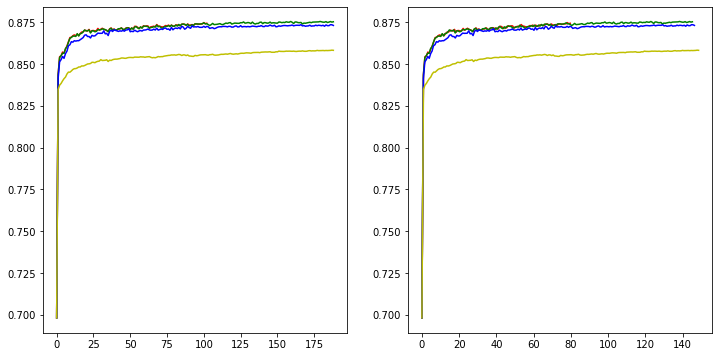

In [0]:
alpha = [0, 0.01, 0.1, 0.5]
hist_alpha = []


for a in alpha:
    print(a)
    clf = SGDClassifier(loss_function='binary_logistic', batch_size = 1000,  step_alpha=2, 
    step_beta=a, tolerance=1e-9, max_iter=10000, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), 
                      trace=True, accuracy = True, X_test = X_test, y_test = y_test)
    hist_alpha.append(history)

tm = [[],[], [], [], [], [], [], []]

for num_i, i in enumerate(hist_alpha):
  sum_time = 0
  for num_j, j in enumerate(i['time']):
    tm[num_i].append(sum_time + j)
    sum_time = sum_time + j


fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred']
for i in range(5):
    ax.plot(np.arange(len(hist_alpha[i]['func'])), hist_alpha[i]['accuracy'], cl[i])
    ax1.plot(tm[i], hist_alpha[i]['accuracy'], cl[i])

ax1.set_xlabel('время, с')
ax1.set_ylabel('точность')
ax1.set_title("точность от времени работы")

ax1.legend(alpha)
ax1.grid()
ax.set_xlabel('номер итерации')
ax.set_ylabel('точность')
ax.set_title("точность от итерации метода")
ax.legend(alpha)
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)
